# Summary of the project from kaggle 

We recognize the works of artists through their unique style, such as color choices or brush strokes. The “je ne sais quoi” of artists like Claude Monet can now be imitated with algorithms thanks to generative adversarial networks (GANs). In this getting started competition, you will bring that style to your photos or recreate the style from scratch!

Computer vision has advanced tremendously in recent years and GANs are now capable of mimicking objects in a very convincing way. But creating museum-worthy masterpieces is thought of to be, well, more art than science. So can (data) science, in the form of GANs, trick classifiers into believing you’ve created a true Monet? That’s the challenge you’ll take on!

The Challenge:
A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

Our task is to build a GAN that generates 7,000 to 10,000 Monet-style images.

# Loading the libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import math
from PIL import Image
import PIL

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import ReLU, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory


from tqdm.notebook import tqdm
import itertools
import time
import shutil
import torch.optim as optim

2024-06-08 17:25:50.461882: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-08 17:25:50.462012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-08 17:25:50.713357: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Acquiring files

In [3]:
monet_path = "../input/gan-getting-started/monet_jpg/"
photo_path = "../input/gan-getting-started/photo_jpg/"

print("Number of monet paintings: {}".format(len(os.listdir(monet_path))))
print("Number of photos: {}".format(len(os.listdir(photo_path))))

Number of monet paintings: 300
Number of photos: 7038


# Image Size

In [4]:
def print_folder_statistics(path):
    d_image_sizes = {}
    for image_name in os.listdir(path):
        image = cv2.imread(os.path.join(path, image_name))
        d_image_sizes[image.shape] = d_image_sizes.get(image.shape, 0) + 1
        
    for size, count in d_image_sizes.items():
        print(f"shape: {size}")


print(f"Monet images:")
print_folder_statistics(monet_path)
print("-" * 10)
print(f"Photo images:")
print_folder_statistics(photo_path)
print("-" * 10)

Monet images:
shape: (256, 256, 3)
----------
Photo images:
shape: (256, 256, 3)
----------


# tensorflow

In [5]:
image_size = (256, 256)
batch_size = 32

monet_ds = image_dataset_from_directory(
    '/kaggle/input/gan-getting-started/monet_jpg',
    label_mode=None,  # No labels are needed
    color_mode='rgb',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True
).map(lambda x: (x / 127.5) - 1).prefetch(tf.data.experimental.AUTOTUNE).cache()

photo_ds = image_dataset_from_directory(
    '/kaggle/input/gan-getting-started/photo_jpg',
    label_mode=None,  
    color_mode='rgb',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True
).map(lambda x: (x / 127.5) - 1).prefetch(tf.data.experimental.AUTOTUNE).cache()

# iterators
sample_monet = next(iter(monet_ds))
sample_photo = next(iter(photo_ds))


Found 300 files.
Found 7038 files.


In [6]:
print(sample_monet.shape)
print(sample_photo.shape)

(32, 256, 256, 3)
(32, 256, 256, 3)


# reviewing the photos

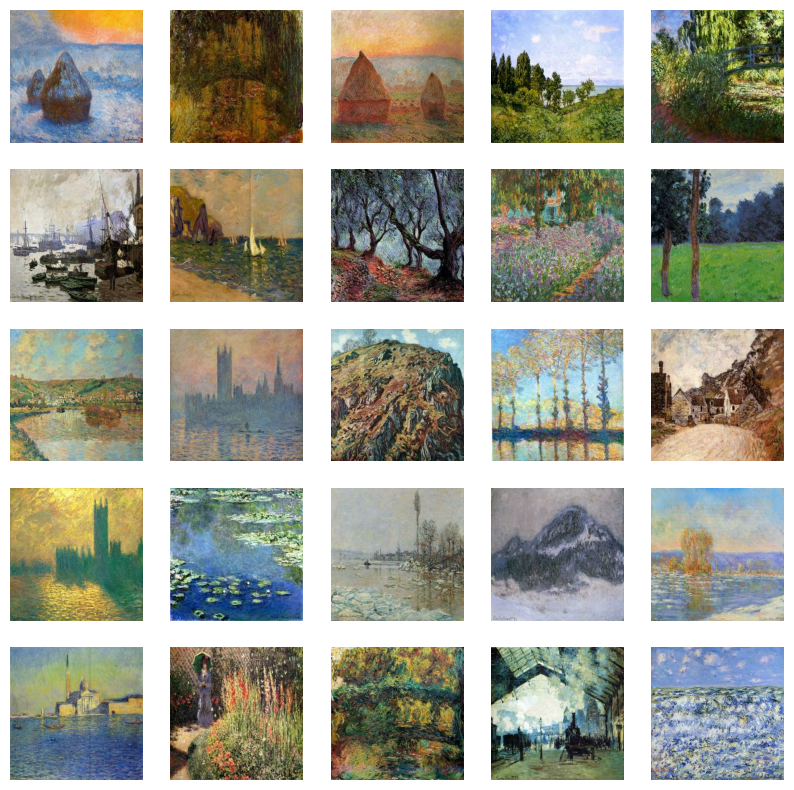

In [7]:
def visualize_images(example):
    plt.figure(figsize = (10, 10))
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(example[i] * 0.5 + 0.5)
        plt.axis("off")
visualize_images(sample_monet)

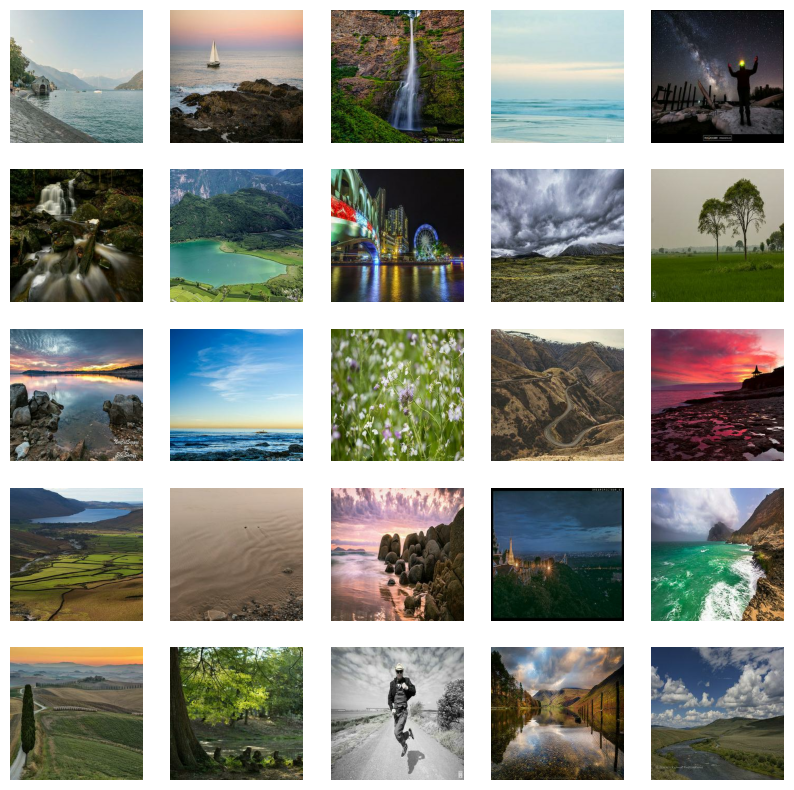

In [8]:
visualize_images(sample_photo)

# GANs are a clever way of training a generative model by framing the problem as a supervised learning problem with two sub-models: the generator model that we train to generate new examples, and the discriminator model that tries to classify examples as either real (from the domain) or fake (generated). The two models are trained together in a zero-sum game, adversarial, until the discriminator model is fooled about half the time, meaning the generator model is generating plausible examples.

# Generator

In [9]:
def create_generator():
    model = Sequential(name="Generator")
    
    n_nodes = 16 * 16 * 512
    model.add(Dense(n_nodes, input_shape=(200,), name='Generator-Hidden-Layer-1'))
    model.add(Reshape((16, 16, 512), name='Generator-Hidden-Layer-Reshape-1'))
   
    model.add(Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-2'))
    model.add(LeakyReLU(alpha=0.2))
        
    model.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-3'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-4'))
    model.add(LeakyReLU(alpha=0.2))
        
    model.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-5'))
    model.add(LeakyReLU(alpha=0.2))
        
    model.add(Conv2DTranspose(3, kernel_size=(3, 3), activation='tanh', strides=(1, 1), padding='same', name='Generator-Output-Layer'))
  
    return model


In [10]:
generator=create_generator()
generator.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Generator-Hidden-Layer-1        │ (None, 131072)         │    26,345,472 │
│ (Dense)                         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Generator-Hidden-Layer-Reshape… │ (None, 16, 16, 512)    │             0 │
│ (Reshape)                       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Generator-Hidden-Layer-2        │ (None, 32, 32, 256)    │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Generator-Hidden-Layer-3        │ (None, 64, 64, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Generator-Hidden-Layer-4        │ (None, 128, 128, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Generator-Hidden-Layer-5        │ (None, 256, 256, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Generator-Output-Layer          │ (None, 256, 256, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,913,539 (106.48 MB)

 Trainable params: 27,913,539 (106.48 MB)

 Non-trainable params: 0 (0.00 B)

# Discriminator

In [11]:
def create_discriminator():
    model = Sequential(name="Discriminator") 
    model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(2, 2), padding='same', input_shape=[256, 256, 3], name='Discriminator-Hidden-Layer-1'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-1'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(2, 2), padding='same', name='Discriminator-Hidden-Layer-2'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-2'))
    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(2, 2), padding='same', name='Discriminator-Hidden-Layer-3'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-3'))
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(2, 2), padding='same', name='Discriminator-Hidden-Layer-4'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-4'))
    model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(2, 2), padding='same', name='Discriminator-Hidden-Layer-5'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-5'))
    model.add(Flatten(name='Discriminator-Flatten-Layer')) 
    model.add(Dropout(0.3, name='Discriminator-Flatten-Layer-Dropout')) 
    model.add(Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')) 
    
    return model


In [12]:
discriminator = create_discriminator()
discriminator.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Discriminator-Hidden-Layer-1    │ (None, 128, 128, 32)   │           896 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Discriminator-Hidden-Layer-Act… │ (None, 128, 128, 32)   │             0 │
│ (LeakyReLU)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Discriminator-Hidden-Layer-2    │ (None, 64, 64, 64)     │        18,496 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Discriminator-Hidden-Layer-Act… │ (None, 64, 64, 64)     │             0 │
│ (LeakyReLU)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Discriminator-Hidden-Layer-3    │ (None, 32, 32, 128)    │        73,856 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Discriminator-Hidden-Layer-Act… │ (None, 32, 32, 128)    │             0 │
│ (LeakyReLU)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Discriminator-Hidden-Layer-4    │ (None, 16, 16, 256)    │       295,168 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Discriminator-Hidden-Layer-Act… │ (None, 16, 16, 256)    │             0 │
│ (LeakyReLU)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Discriminator-Hidden-Layer-5    │ (None, 8, 8, 512)      │     1,180,160 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Discriminator-Hidden-Layer-Act… │ (None, 8, 8, 512)      │             0 │
│ (LeakyReLU)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Discriminator-Flatten-Layer     │ (None, 32768)          │             0 │
│ (Flatten)                       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Discriminator-Flatten-Layer-Dr… │ (None, 32768)          │             0 │
│ (Dropout)                       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Discriminator-Output-Layer      │ (None, 1)              │        32,76

 Total params: 1,605,185 (6.12 MB)

 Trainable params: 1,603,265 (6.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

# Loss function

In [13]:
def generator_loss(fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    generator = create_generator()  
    discriminator = create_discriminator()  
    generator_optimizer = tf.keras.optimizers.Adam(1e-4)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [15]:
EPOCHS = 1000
BATCH_SIZE = 32
noise_dim = 200
shape_dim = [256,256,3]

# A Deep Convolutional Generative Adversarial Network (DCGAN) is a type of Generative Adversarial Network (GAN) designed specifically for image generation tasks. It employs convolutional neural networks (CNNs) in the generator and discriminator, enabling it to capture spatial features effectively.

In [18]:
class DCGAN_model:
    def __init__(self, noise_dim, EPOCHS, BATCH_SIZE, generator, discriminator, dataset):  
        self.noise_dim = noise_dim
        self.EPOCHS = EPOCHS
        self.BATCH_SIZE = BATCH_SIZE
        self.generator = generator
        self.discriminator = discriminator
        self.dataset = dataset
    
    @tf.function
    def train(self, images):
    
        noise = tf.random.normal([images.shape[0], noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
            generated_images = generator(noise, training=True)
    
            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images, training=True)
    
            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        return (gen_loss + disc_loss) * 0.5
    
    @tf.function
    def distributed_train(self, images):
        per_replica_losses = strategy.run(self.train, args=(images,))
        return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)
    
    def generate_images(self):
        noise = tf.random.normal([self.BATCH_SIZE, self.noise_dim]) 
        predictions = self.generator(noise, training=False)  
        return predictions
        
    def generate_and_plot_images(self):      
        image = self.generate_images()
        gen_imgs = 0.5 * image + 0.5
        gen_imgs = gen_imgs.numpy()  
        fig = plt.figure(figsize=(10, 10))
        for i in range(25):
            plt.subplot(5, 5, i+1)
            plt.imshow(gen_imgs[i, :, :, :])
            plt.axis('off')
        plt.show()

    def train_loop(self):
        for epoch in range(self.EPOCHS):
            start = time.time()

            total_loss = 0.0
            num_batches = 0

            for image_batch in self.dataset:
                loss = self.distributed_train(image_batch)
                total_loss += tf.reduce_mean(loss)
                num_batches += 1
            mean_loss = total_loss / num_batches

            if (epoch+1) % 500 == 0:                                  
                print ('Time for epoch {} is {} sec, total loss is {}'.format(epoch + 1, time.time()-start, mean_loss))
                self.generate_and_plot_images()


# DGCAN Model

Time for epoch 500 is 2.532073497772217 sec, total loss is 1.7686532735824585


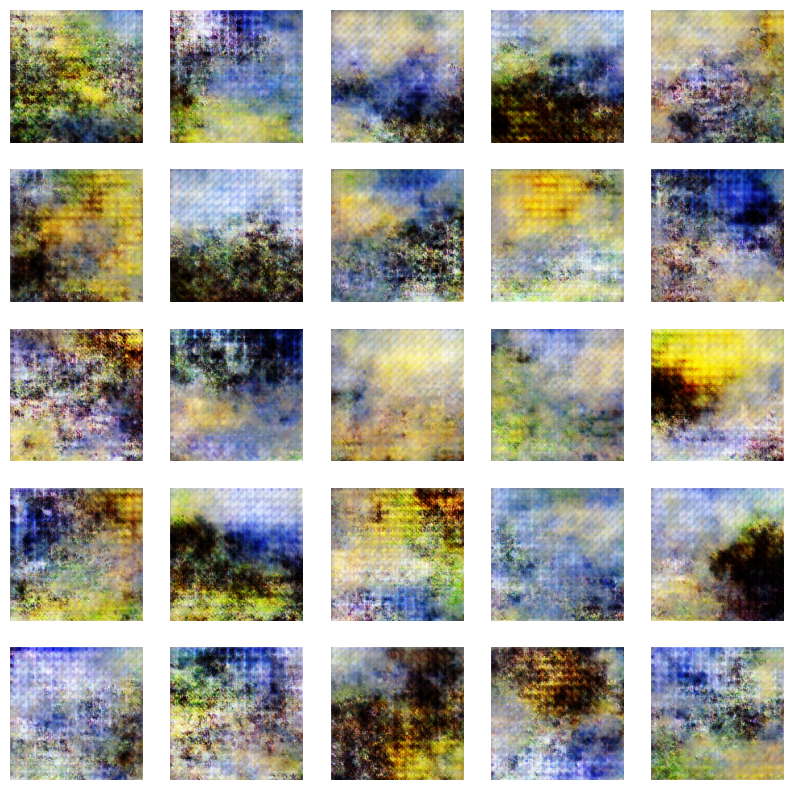

Time for epoch 1000 is 2.5355722904205322 sec, total loss is 1.7710702419281006


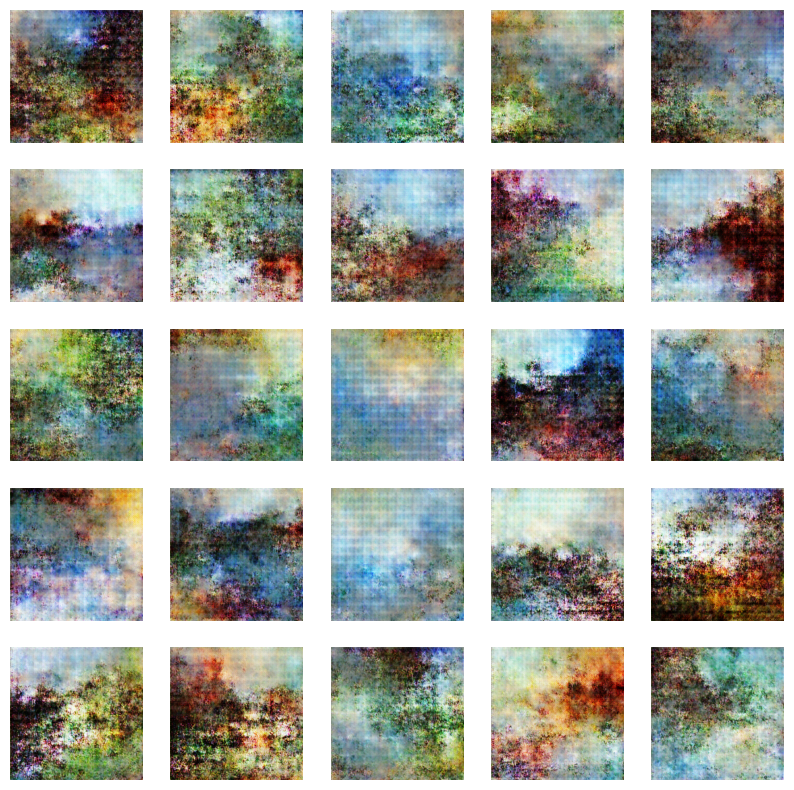

In [19]:
dcgan = DCGAN_model(noise_dim, EPOCHS, BATCH_SIZE, generator, discriminator, monet_ds)
dcgan.train_loop()

# Saving images

In [20]:
!mkdir ../images # To save the images

# Creating images 

In [22]:
output_dir = "../images/"
os.makedirs(output_dir, exist_ok=True)

with strategy.scope():
    for i in range(8000):
        noise = tf.random.normal([BATCH_SIZE, noise_dim])
        img = generator(noise, training=False) 
        img = 0.5 * img + 0.5
        img = (img * 255).numpy().astype('uint8') 
        img = Image.fromarray(img[0])  
        img.save(os.path.join(output_dir, f"{i}.jpg"))


# images

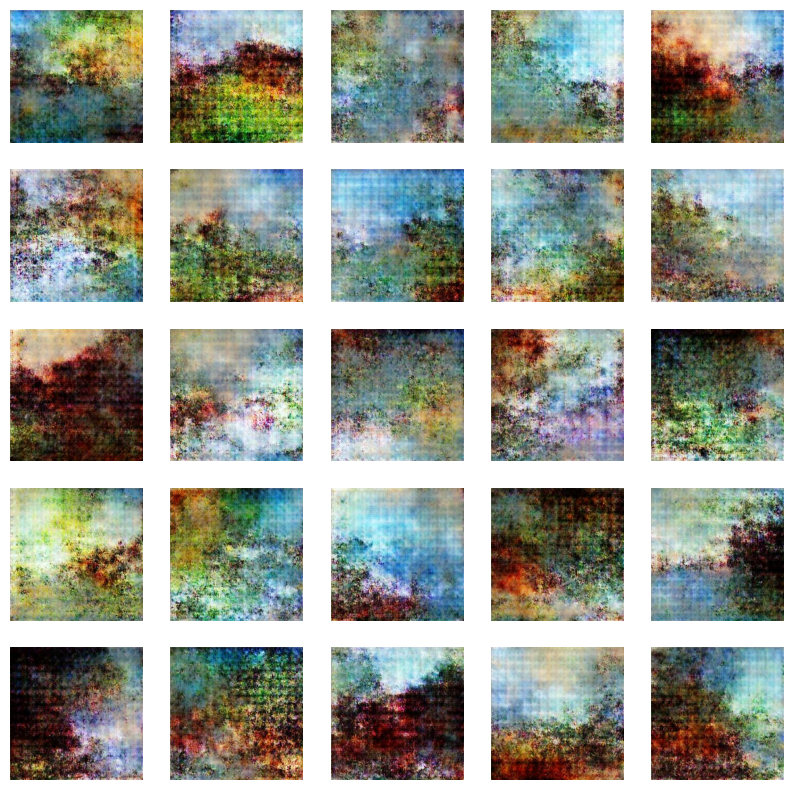

In [23]:
fig = plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(PIL.Image.open("../images/" + str(i) + ".jpg"))
    plt.axis('off')
plt.show()

# Moving it to the output folder to be submitted to the competition

In [24]:
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")


'/kaggle/working/images.zip'

# Conclusion:

There are other GAN's such as CycleGAN, StyleGAN. These would generate much better results that the basic model.  

There can be other hyperparameters such as number of layers in each of the generator and discriminator network
